In [1]:
### Data import
# Handling URL queries
import json
import requests
# Import BeautifulSoup for scraping table from wiki-page
from bs4 import BeautifulSoup
# Read environment variables with foursquare API credentials
import os


### Data preparation
# Pandas and numpy for analysing and preparing data
import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None) # display all columns of a df inline
pd.set_option('display.max_rows', None) # display all rows of a df inline
import numpy as np


### Data Plotting
# Seaborn and Matplotlib for plotting data
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# Matplotlib colors
import matplotlib.cm as cm
import matplotlib.colors as colors


### Handling and visualization of Geo Data
# Folium and geopy handle and display geospatial data
import folium # display data on interactive map
from geopy.geocoders import Nominatim # get langitude and longitude for an address
# GeoPandas for handling GeoJSON
import geopandas as gpd


### Data Modeling and analysis
# Statistical analysis
import statsmodels as sm
# To cluster neighborhoods
from sklearn.cluster import KMeans


Print tables always on the left side of the cell.

In [2]:
%%html
<style>
table {display:block}
</style>

Define general purpose functions

In [95]:
def describe_data(df):
    
    #Remove geometry information as it disturbs .info and .describe overviews
    col_dtypes = df.dtypes
    columns_to_drop = col_dtypes[col_dtypes == 'geometry'].index.to_list()
    df_dropped = df.drop(columns_to_drop, axis=1)
    
    print(f'Shape:')
    print(df.shape)
    print(f'\nHead:')
    display(df.head())
    if len(columns_to_drop) > 0:
        print(f'The coordinate reference system of the geometry data is set as: {df.crs}')
        print(f'\n!!! {len(columns_to_drop)} column(s) with geometry data have been removed and are not considered in "Info" and "Description": {columns_to_drop} !!!')
    print(f'\nInfo:')
    display(df_dropped.info())
    print(f'\nDescription:')
    display(df_dropped.describe(exclude='geometry'))


# Business Understanding

# Data Understanding and Preparation

Data sources:

https://public.opendatasoft.com provides data on the borders of the neighborhoods, as well as on the population.  
https://de.foursquare.com provides data on venue recommendations around a defined geo location

## Optional data sources

In [ ]:
# Download GeoJSON for geo coordinates of residential areas in Duesseldorf
!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Wohnquartiere_Duesseldorf_WGS84_4326.geojson' -O dus_residential_areas.geojson

# Download JSON with movements into the areas (2017)
# Description of Data: https://opendata.duesseldorf.de/dataset/bevölkerungswanderung-den-wohnquartieren-düsseldorf
!wget --quiet 'https://opendata.duesseldorf.de/api/action/datastore/search.json?resource_id=1564e254-213c-4b35-a1a9-b0e8a070ced0&limit=400' -O dus_move_in.json

# Download JSON with movements out of the areas (2017)
# Description of Data: https://opendata.duesseldorf.de/dataset/bevölkerungswanderung-den-wohnquartieren-düsseldorf
!wget --quiet 'https://opendata.duesseldorf.de/api/action/datastore/search.json?resource_id=b7f96ca0-735d-4c9b-862c-99813429e0cd&limit=400' -O dus_move_out.json

## Neighborhoods

The focus on the neighboords data is to achieve a complete list of all neighboorhoods in Duesseldorf and get the coordinates of their geographical borders. The data is provided by the city of Duesseldorf.

### Collect Initial Data

In [ ]:
# Download GeoJSON for geo coordinates of neighborhoods in Duesseldorf
# Description of the data: https://opendata.duesseldorf.de/dataset/zuordnung-der-stadtteile-zu-den-stadtbezirken-von-d%C3%BCsseldorf
!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Stadtteile_WGS84_4326.geojson' -O dus_neighborhoods.geojson

### Describe, explore data and verify quality

In [4]:
neighborhoods_orig = gpd.read_file('dus_neighborhoods.geojson', crs='+init=epsg:4326')
neighborhoods_orig = neighborhoods_orig.astype({'Stadtbezirk' : 'str', 'Stadtteil': 'str'})
describe_data(neighborhoods_orig)

Shape:
(50, 6)

Head:


Quelle       Stand Stadtbezirk Stadtteil        Name  \
0  Amt 12/2  31.12.2017           5        54    Wittlaer   
1  Amt 12/2  31.12.2017           5        55   Angermund   
2  Amt 12/2  31.12.2017           4        43      Lörick   
3  Amt 12/2  31.12.2017           4        42      Heerdt   
4  Amt 12/2  31.12.2017           4        41  Oberkassel   

                                            geometry  
0  POLYGON ((6.76623 51.31355, 6.76618 51.31359, ...  
1  POLYGON ((6.80952 51.34292, 6.80948 51.34302, ...  
2  POLYGON ((6.74610 51.25203, 6.74602 51.25205, ...  
3  POLYGON ((6.73560 51.23767, 6.73522 51.23780, ...  
4  POLYGON ((6.76868 51.23195, 6.76868 51.23196, ...


!!! 1 column(s) with geometry data have been removed and are not considered in "Info" and "Description": ['geometry'] !!!

Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
Quelle         50 non-null object
Stand          50 non-null object
Stadtbezirk    50 non-null object
Stadtteil      50 non-null object
Name           50 non-null object
dtypes: object(5)
memory usage: 2.1+ KB


None


Description:


Quelle       Stand Stadtbezirk Stadtteil    Name
count         50          50          50        50      50
unique         1           1          10        50      50
top     Amt 12/2  31.12.2017           3        54  Garath
freq          50          50           8         1       1

**Description of columns:**<br>
<table id="neighborhoods"><tr><th>Column</th><th>Translation</th><th>Description</th></tr><tr><td>Quelle</td><td>Source</td><td>Name of the city department that has created the data.</td></tr><tr><td>Stand</td><td>Status</td><td>Date of the data.</td></tr><tr><td>Stadtbezirk</td><td>Department</td><td>ID of the department.</td></tr><tr><td>Stadtteil</td><td>Neighborhood ID</td><td>ID of the neighborhood.</td></tr><tr><td>Name</td><td>Neighborhood</td><td>Name of the neighborhood.</td></tr><tr><td>geometry</td><td>geometry</td><td>Description of the borders of each neighborhood as polygon geo coordinates.</td></tr></table>

**Content:**<br>
The data of the neighboorhoods has been created by the department 'Amt 12/2' of the citiy of Duesseldorf with status of December 31st, 2017. The city area of Duesseldorf is divided into 10 departments and 50 neighborhoods. Each neighborhood is assigned to one department. Departments only have an ID and no name, whereas neighborhoods have an ID and a name. The neighborhood ID is a merged key based on the ID of the department and a digit for the neighborhood.<br>
As the analysis will be based on the neighborhoods only the columns 'Neighborhood ID', 'Neighborhood and 'geometry' will be used.<br>
<br>
**Quality:**<br>
The data does not include any null-values.<br>
<br>
**Data Formatting:**
- Drop not required columns
- Translate column headers to english
- Format the Neighborhood ID to three digit - add a leading 0 in case of only two digits
- Set index of DataFrame to 'Neighborhood ID' (unique!)

In [5]:
neighborhoods = (neighborhoods_orig.drop(['Quelle', 'Stand', 'Stadtbezirk'], axis=1) # Drop not required columns
                                   .rename(columns={'Stadtteil': 'Neighborhood ID',
                                                    'Name': 'Neighborhood'
                                                   }) # Translate column headers
                                   .sort_values(by='Neighborhood ID', ascending=True) # Sort table by neighborhood id
                                   .assign(**{'Neighborhood ID': lambda x: x['Neighborhood ID'].map(lambda v: f'{int(v):03d}')}) # Convert ID to three digit str
                                   .set_index('Neighborhood ID')
                )

neighborhoods.head()

Neighborhood  \
Neighborhood ID                
101                   Garath   
102                Hellerhof   
011                 Altstadt   
012                Carlstadt   
013               Stadtmitte   

                                                          geometry  
Neighborhood ID                                                     
101              POLYGON ((6.91823 51.14008, 6.91822 51.14009, ...  
102              POLYGON ((6.92512 51.13657, 6.92486 51.13708, ...  
011              POLYGON ((6.77727 51.23037, 6.77726 51.23047, ...  
012              POLYGON ((6.77569 51.22498, 6.77563 51.22501, ...  
013              POLYGON ((6.79958 51.22495, 6.79956 51.22496, ...

### Data Analysis and Preparation

In [6]:
print(neighborhoods.crs)

None


The CRS (Coordinate Reference System) was not provided by the geojson, so it has to be set manually. The information of the CRS of the file is provided on the webpage.

In [7]:
neighborhoods.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
neighborhoods.head()

Neighborhood  \
Neighborhood ID                
101                   Garath   
102                Hellerhof   
011                 Altstadt   
012                Carlstadt   
013               Stadtmitte   

                                                          geometry  
Neighborhood ID                                                     
101              POLYGON ((6.91823 51.14008, 6.91822 51.14009, ...  
102              POLYGON ((6.92512 51.13657, 6.92486 51.13708, ...  
011              POLYGON ((6.77727 51.23037, 6.77726 51.23047, ...  
012              POLYGON ((6.77569 51.22498, 6.77563 51.22501, ...  
013              POLYGON ((6.79958 51.22495, 6.79956 51.22496, ...

Get the geo coordinates of the center of Duesseldorf.

In [8]:
dus_centre = Nominatim(user_agent='dus')
location = dus_centre.geocode(query='Düsseldorf', country_codes='de')
dus_latitude = location.latitude
dus_longitude = location.longitude

print(f'The coordinates of Duesseldorf are {dus_latitude}, {dus_longitude}.')

The coordinates of Duesseldorf are 51.2254018, 6.7763137.


Show a centered map of Duesseldorf and visualize the neighborhoods.

In [9]:
# create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

folium.GeoJson(data=neighborhoods[['geometry', 'Neighborhood']],
               tooltip=folium.features.GeoJsonTooltip(['Neighborhood'])
              ).add_to(map_dus)

map_dus

The size and composition of area types (e.g. green, industrial or city areas) vary largely between the different neighborhoods. E.g. Kalkum (North) and Unterbach (Southeast) consist of large green or water areas. Whereas Stadmitte appears to be a total city area.

## Population

The population data should provide the total number of population by the end of the year in each neighborhood of Duesseldorf. The data is provided by the city of Duesseldorf and considers the number of people that have officially registered to be living in the neighborhood.

### Collect initial data

In [ ]:
# Download CSV (JSON file was not available) with total size of population per neighborhood in Duesseldorf (2012 - 2018)
# Description of Data: https://opendata.duesseldorf.de/dataset/einwohnerzahl-d%C3%BCsseldorf-seit-2012-einwohnermeldedaten
!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Bev%C3%B6lkerungsstand%20in%20den%20Stadtteilen%20seit%202012_0.csv' -O dus_population.csv

### Describe, explore data and verify quality

In [10]:
population_import = pd.read_csv('dus_population.csv', sep=';')
describe_data(population_import)

Shape:
(50, 9)

Head:


Stadtteilnummer Stadtteilname   2012   2013   2014   2015   2016   2017  \
0               11      Altstadt   2232   2253   2221   2264   2244   2358   
1               12     Carlstadt   2290   2323   2315   2491   2588   2279   
2               13    Stadtmitte  13900  13953  14388  14680  15008  14840   
3               14    Pempelfort  29931  30345  30814  31449  31897  32626   
4               15     Derendorf  19740  19927  20005  20232  20401  20651   

    2018  
0   2404  
1   2285  
2  14954  
3  33064  
4  20610


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
Stadtteilnummer    50 non-null int64
Stadtteilname      50 non-null object
2012               50 non-null object
2013               50 non-null object
2014               50 non-null int64
2015               50 non-null int64
2016               50 non-null int64
2017               50 non-null int64
2018               50 non-null int64
dtypes: int64(6), object(3)
memory usage: 3.6+ KB


None


Description:


Stadtteilnummer Stadtteilname   2012   2013          2014  \
count          50.00000            50     50     50     50.000000   
unique              NaN            50     50     50           NaN   
top                 NaN         Itter  29715  19927           NaN   
freq                NaN             1      1      1           NaN   
mean           56.36000           NaN    NaN    NaN  12393.020000   
std            28.33168           NaN    NaN    NaN   9802.753111   
min            11.00000           NaN    NaN    NaN    139.000000   
25%            34.25000           NaN    NaN    NaN   4493.250000   
50%            54.50000           NaN    NaN    NaN  10164.500000   
75%            81.75000           NaN    NaN    NaN  18723.500000   
max           102.00000           NaN    NaN    NaN  39708.000000   

                2015          2016          2017        2018  
count      50.000000     50.000000     50.000000     50.0000  
unique           NaN           NaN           NaN         NaN  
top              NaN           NaN           NaN         NaN  
freq             NaN           NaN           NaN         NaN  
mean    12568.740000  12714.080000  12788.140000  12846.0800  
std      9902.447485   9954.961019  10051.902206  10093.9587  
min       131.000000    130.000000    116.000000    109.0000  
25%      4613.500000   4701.000000   4730.250000   4778.2500  
50%     10303.000000  10431.000000  10427.000000  10471.0000  
75%     19026.500000  19049.500000  19254.750000  19304.7500  
max     39899.000000  40038.000000  40552.000000  40651.0000

**Description of columns:**<br>
<table id="population"><tr><th>Column</th><th>Translation</th><th>Description</th></tr><tr><td>Stadtteilnummer</td><td>Neighborhood ID</td><td>ID of the neighborhood.</td></tr><tr><td>Stadtteilname</td><td>Neighborhood</td><td>Name of the neighborhood.</td></tr><tr><td>2012-2018</td><td>2012-2018</td><td>Size of population per neighborhood at the end of the year.</td></tr></table>

**Content:**<br>
The data includes the total population of each neighborhood by the end of the years 2012 to 2018. The population data is provided for all 50 neighborhoods.<br>
For the analysis the data for the past five years (2013 to 2018) will be used.<br>
<br>
**Quality:**<br>
The data does not include any null-values. The data type of columns 2012 and 2013 has been recognized as 'object', whereas it should contain only numerical values, such as 2014 to 2018. This needs to be cleaned.<br>
<br>
**Data Formatting:**
- Drop not required columns
- Translate column headers to english
- Format the Neighborhood ID to three digit - add a leading 0 in case of only two digits
- Set index of DataFrame to 'Neighborhood ID' (unique!)
- Analyse data of 2013 and transform data type of column to integer

In [11]:
population = (population_import.drop(['2012'], axis=1)
                               .rename(columns={'Stadtteilnummer': 'Neighborhood ID', 'Stadtteilname': 'Neighborhood'}) # Translate column headers
                               .assign(**{'Neighborhood ID': lambda x: x['Neighborhood ID'].map(lambda v: f'{v:03d}')}) # Convert ID to three digit str
                               .set_index('Neighborhood ID')
             )
population.head()

Neighborhood   2013   2014   2015   2016   2017   2018
Neighborhood ID                                                       
011                 Altstadt   2253   2221   2264   2244   2358   2404
012                Carlstadt   2323   2315   2491   2588   2279   2285
013               Stadtmitte  13953  14388  14680  15008  14840  14954
014               Pempelfort  30345  30814  31449  31897  32626  33064
015                Derendorf  19927  20005  20232  20401  20651  20610

Analyse data of column '2013' to convert column to integer.

In [12]:
population['2013'] = population['2013'].map(lambda x: int(x) if x.isdigit() else x)
population[population['2013'].map(lambda x: type(x).__name__ == 'str')]

Neighborhood 2013  2014  2015  2016  2017  2018
Neighborhood ID                                                
075               Knittkuhl*    X  2055  2048  2078  2091  2097

In [13]:
population.loc[['074', '075'],:]

Neighborhood  2013  2014  2015  2016  2017  2018
Neighborhood ID                                                 
074              Hubbelrath*  3646  1571  1535  1722  1645  1612
075               Knittkuhl*     X  2055  2048  2078  2091  2097

According to the data description on opendata.duesseldorf.de, in march 2014 a part of neighborhood '074 Hubbelrath' was separated and assigned to new neighborhood '075 Knittkuhl'. To be able to use the 2013 data for all neighborhoods, the popultion of '074 Hubbelrath' will be distributed to '075 Knittkuhl' according to shares in 2014.

In [14]:
# Extract values for both neighborhoods in 2014
neighborhood_split = population.sort_index(ascending=True).loc[['074', '075'], '2014'].values
# Calculate the share of 'Knittkuhl'
knittkuhl_share = neighborhood_split[1] / neighborhood_split.sum()

# Overwrite the values for 2013 for both neighborhoods
population.at['075', '2013'] = int(population.at['074', '2013'] * knittkuhl_share)
population.at['074', '2013'] = population.at['074', '2013'] - population.at['075', '2013']

# Change data type of column to integer
population['2013'] = population['2013'].astype('int64')

In [15]:
population.loc[['074', '075'],:]

Neighborhood  2013  2014  2015  2016  2017  2018
Neighborhood ID                                                 
074              Hubbelrath*  1580  1571  1535  1722  1645  1612
075               Knittkuhl*  2066  2055  2048  2078  2091  2097

### Data Analysis and Preparation

Visualize the development of the total population from 2013 to 2018.

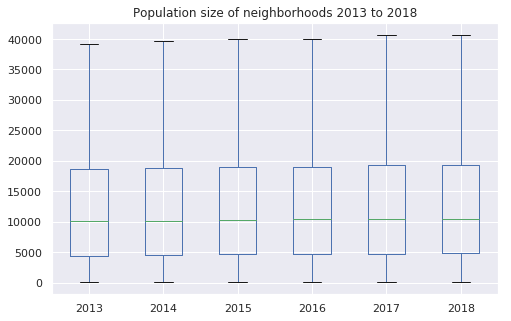

In [16]:
sns.set()

fig, ax0 = plt.subplots(figsize=(8,5))
population.plot(kind='box', ax=ax0)
ax0.set_title('Population size of neighborhoods 2013 to 2018');

4.7% average growth of population.



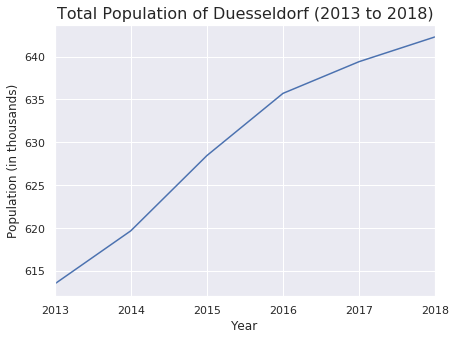

In [17]:
sns.set()

fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(1,2,1)
year_on_year = population.drop('Neighborhood', axis=1).sum(axis=0) # Calculate totals per year
year_on_year.plot(kind='line', ax=ax0)
ax0.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)//1000, ','))) # Format y-label in thousands
ax0.set_title('Total Population of Duesseldorf (2013 to 2018)', fontdict={'fontsize': 16})
ax0.set_ylabel('Population (in thousands)')
ax0.set_xlabel('Year');

av_growth = round((year_on_year['2018'] - year_on_year['2013']) * 100 / year_on_year['2013'], 1)
print(f'{av_growth}% average growth of population.\n')

Steady growth of the population by a total of 4.7% from 2013 to 2018 with a slowing tendency in the last two years.<br>
<br>
Analyse the distribution of population size of the neighborhoods in 2018.

Continue analysis on neighborhood level and calculate year-on-year as well as total growth per neighborhood.

In [18]:
def calc_population_dev(df, leading_cols):
    
    # Copy first two columns of DataFrame to ensure handed-over df is not changed
    df_tot = df.iloc[:, 0:leading_cols].copy()
    df_rel = df.iloc[:, 0:leading_cols].copy()
    
    # Add data per year as columns
    columns = df.columns[0:leading_cols].to_list()
    for col in range(leading_cols, len(df.columns)):
        actual_col = df.columns[col]
        prev_col = df.columns[(col-1)]
        df_tot[actual_col] = df[actual_col] - df[prev_col] # Calculate total change in population
        df_rel[actual_col] = round((df[actual_col] - df[prev_col]) * 100 / df[prev_col], 1) # Calculate relative change in population
    
    # Add total change from first to last year
    df_tot['Total'] = df.iloc[:,(len(df.columns)-1)] - df.iloc[:,(leading_cols+1)]
    df_rel['Total'] = round((df.iloc[:,(len(df.columns)-1)] - df.iloc[:,(leading_cols+1)]) * 100 / df.iloc[:,(leading_cols+1)], 1)
    
    return df_tot, df_rel

In [19]:
population_tot, population_rel = calc_population_dev(population, 2)

In [20]:
population_tot.head()

Neighborhood   2013  2014  2015  2016  2017  2018  Total
Neighborhood ID                                                         
011                 Altstadt   2253   -32    43   -20   114    46    140
012                Carlstadt   2323    -8   176    97  -309     6   -206
013               Stadtmitte  13953   435   292   328  -168   114    274
014               Pempelfort  30345   469   635   448   729   438   1615
015                Derendorf  19927    78   227   169   250   -41    378

In [25]:
population_tot['Total'].sum()

13867

In [21]:
population_rel.head()

Neighborhood   2013  2014  2015  2016  2017  2018  Total
Neighborhood ID                                                         
011                 Altstadt   2253  -1.4   1.9  -0.9   5.1   2.0    6.2
012                Carlstadt   2323  -0.3   7.6   3.9 -11.9   0.3   -8.3
013               Stadtmitte  13953   3.1   2.0   2.2  -1.1   0.8    1.9
014               Pempelfort  30345   1.5   2.1   1.4   2.3   1.3    5.1
015                Derendorf  19927   0.4   1.1   0.8   1.2  -0.2    1.9

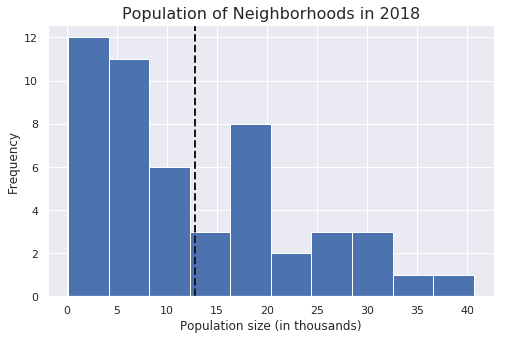

In [22]:
sns.set()

fig, ax0 = plt.subplots(figsize=(8,5))

population['2018'].plot(kind='hist', bins=10)
plt.axvline(population['2018'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.title('Population of Neighborhoods in 2018', fontdict={'fontsize': 16})
ax0.set_xlabel('Population size (in thousands)')
ax0.set_ylabel('Frequency')

ax0.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: int(x)//1000));

In [23]:
population_geo = neighborhoods.join(population.drop('Neighborhood', axis=1))
population_geo.head()

Neighborhood  \
Neighborhood ID                
101                   Garath   
102                Hellerhof   
011                 Altstadt   
012                Carlstadt   
013               Stadtmitte   

                                                          geometry   2013  \
Neighborhood ID                                                             
101              POLYGON ((6.91823 51.14008, 6.91822 51.14009, ...  18470   
102              POLYGON ((6.92512 51.13657, 6.92486 51.13708, ...   6071   
011              POLYGON ((6.77727 51.23037, 6.77726 51.23047, ...   2253   
012              POLYGON ((6.77569 51.22498, 6.77563 51.22501, ...   2323   
013              POLYGON ((6.79958 51.22495, 6.79956 51.22496, ...  13953   

                  2014   2015   2016   2017   2018  
Neighborhood ID                                     
101              18729  19068  19042  19143  19109  
102               5980   5913   6041   5969   5882  
011               2221   2264   2244   2358   2404  
012               2315   2491   2588   2279   2285  
013              14388  14680  15008  14840  14954

In [24]:
# Create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

# Generate choropleth map to show postal code areas
choropleth = folium.Choropleth(population_geo,
                               key_on='feature.properties.Neighborhood',
                               data=population_geo,
                               columns=['Neighborhood', '2018'],
                               bins=9,
                               fill_color='YlOrRd',
                               fill_opacity=0.7,
                               line_opacity=0.5,
                               legend_name='Population per Neighborhood'
                              ).add_to(map_dus)

choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['Neighborhood', '2018']))

map_dus

Mean population size at around 13.5 thousand. 23 of 50 neighborhoods have a populuation of less than 8 thousand employees.

KeyError: '2013-2018 (abs)'

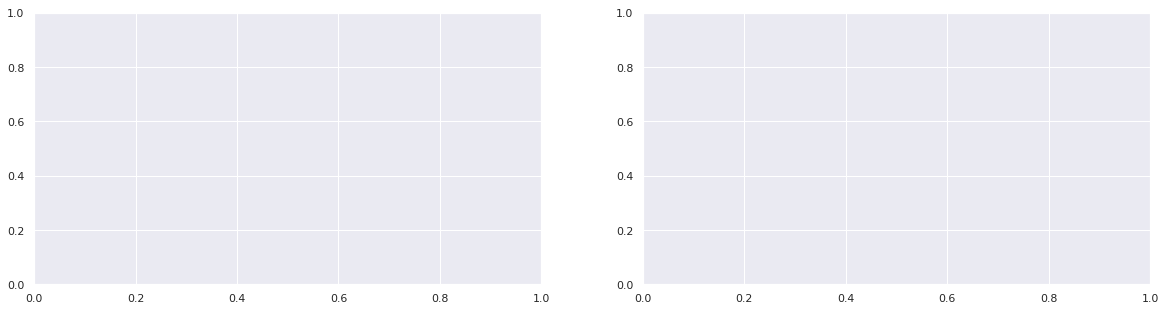

In [26]:
fig = plt.figure(figsize=(20,5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

population['2013-2018 (abs)'].plot(kind='hist', bins=20, ax=ax0)
population['2013-2018 (perc)'].plot(kind='hist', bins=20, yticks=range(0, 19, 2), ax=ax1)
ax0.set_title('Change of Population per Neighborhood 2013-2018 (abs)', fontdict={'fontsize': 16})
ax1.set_title('Change of Population per Neighborhood 2013-2018 (perc)', fontdict={'fontsize': 16});

In [ ]:
sns.set()
change = population[['Neighborhood', '2013-2018 (abs)', '2013-2018 (perc)']].sort_values(by='2013-2018 (abs)')
pos_neg = (population['2013-2018 (perc)'] > 0).map({True: 'g', False: 'r'})

fig = plt.figure(figsize=(20,12))

ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
fig.subplots_adjust(hspace=0.45)
sns.barplot(data=change, x='Neighborhood', y='2013-2018 (abs)', hue=pos_neg, dodge=False, ax=ax0)
sns.barplot(data=change, x='Neighborhood', y='2013-2018 (perc)', hue=pos_neg, dodge=False, ax=ax1)
ax0.set_title('Change of Population per Neighborhood 2013-2018 (abs)', fontdict={'fontsize': 16})
ax0.set_xlabel('')
ax0.legend_.remove()
ax0.tick_params(axis='x', rotation=90)
ax1.set_title('Change of Population per Neighborhood 2013-2018 (perc)', fontdict={'fontsize': 16})
ax1.set_xlabel('')
ax1.legend_.remove()
ax1.tick_params(axis='x', rotation=90);

In [ ]:
sns.set()
change = population[['Neighborhood', '2013-2018 (abs)', '2013-2018 (perc)']].sort_values(by='2013-2018 (abs)')
pos_neg = (population['2013-2018 (perc)'] > 0).map({True: 'g', False: 'r'})

fig = plt.figure(figsize=(20,7))

ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
sns.boxplot(data=change, y='2013-2018 (abs)', ax=ax0)
sns.boxplot(data=change, y='2013-2018 (perc)', ax=ax1)
ax0.set_xlabel('')
ax0.tick_params(axis='x', rotation=90)
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=90);

In [ ]:
stats_perc = sm.stats.weightstats.DescrStatsW(population['2013-2018 (perc)'])
print(f'Mean: {stats_perc.mean}')
print(f'Confidence Interval: {stats_perc.tconfint_mean(alpha=0.05)}')
print(f'test of Null hypothesis for mean: {stats_perc.ttest_mean(0)}')

In [ ]:
dus_data_geo[(dus_data_geo['Neighborhood'] == 'Unterbilk') | (dus_data_geo['Neighborhood'] == 'Hafen')]

## Social areas

### Collect initial data

In [177]:
# Download GeoJSON for geo coordinates of social areas in Duesseldorf
# Description of the data: https://opendata.duesseldorf.de/dataset/sozialraumgrenzen-d%C3%BCsseldorf
!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Sozialr%C3%A4ume_WGS84_4326.geojson' -O dus_social_areas.geojson

# Download JSON for geography and environment of social areas in Duesseldorf
# Description of the data: https://opendata.duesseldorf.de/dataset/geographie-und-umwelt-der-sozialr%C3%A4ume-von-d%C3%BCsseldorf
!wget --quiet 'https://opendata.duesseldorf.de/api/action/datastore/search.json?resource_id=562ccddf-862a-4519-8302-f301a0cbe092&limit=200' -O dus_social_areas_data.json

### Describe, explore data and verify quality

#### Geolocation Data

In [119]:
social_geo_orig = gpd.read_file('dus_social_areas.geojson')
social_geo_orig = social_orig.astype({'Sozialraum7': 'str', 'Sozialraum4': 'str'})
describe_data(social_geo_orig)

Shape:
(179, 6)

Head:


OBJEKT  STADTBEZ Sozialraum7 Sozialraum4    Quelle  \
0  Region         5      506053         506  Amt 12/2   
1  Region         4      409043         409  Amt 12/2   
2  Region         4      411043         411  Amt 12/2   
3  Region         6      604063         604  Amt 12/2   
4  Region         6      607064         607  Amt 12/2   

                                            geometry  
0  POLYGON ((6.73981 51.30221, 6.73912 51.30235, ...  
1  POLYGON ((6.72762 51.24037, 6.72785 51.24064, ...  
2  POLYGON ((6.72426 51.24696, 6.72440 51.24771, ...  
3  POLYGON ((6.82758 51.26707, 6.82614 51.26850, ...  
4  POLYGON ((6.80817 51.25976, 6.80728 51.26016, ...

The coordinate reference system of the geometry data is set as: None

!!! 1 column(s) with geometry data have been removed and are not considered in "Info" and "Description": ['geometry'] !!!

Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 5 columns):
OBJEKT         179 non-null object
STADTBEZ       179 non-null int64
Sozialraum7    179 non-null object
Sozialraum4    179 non-null object
Quelle         179 non-null object
dtypes: int64(1), object(4)
memory usage: 7.1+ KB


None


Description:


OBJEKT    STADTBEZ Sozialraum7 Sozialraum4    Quelle
count      179  179.000000         179         179       179
unique       1         NaN         177         179         1
top     Region         NaN           0         308  Amt 12/2
freq       179         NaN           3           1       179
mean       NaN    5.536313         NaN         NaN       NaN
std        NaN    2.719586         NaN         NaN       NaN
min        NaN    1.000000         NaN         NaN       NaN
25%        NaN    3.000000         NaN         NaN       NaN
50%        NaN    6.000000         NaN         NaN       NaN
75%        NaN    8.000000         NaN         NaN       NaN
max        NaN   10.000000         NaN         NaN       NaN

**Content:**<br>
The data includes the geo location data for the 179 social areas in Düsseldorf with status 2018. The social areas are mapped to the departments and with three exceptions, also to neighborhoods. The key in column "Sozialraum7" is a merged key, in which the last three digits represent the corresponding Neighborhood ID and all digits before that represent the Social Area ID ('Sozialraum4').<br>
As transparent in the 'Description' of the DataFrame, the value '0' is appearing three times in the column 'Sozialraum7'. All other values are unique. The three '0' entries need to be further analyzed and decided on how to cope with those.<br>
<br>
**Quality:**<br>
The data does not include any null-values. The coordinate reference system for the geometrical data has not been provided in the geojson. It needs to be set manually.<br>
<br>
**Data Formatting:**
- Set coordinate reference system as referenced on the webpage of the data source
- Analyse the three '0' in 'Sozialraum7' and decide on how to handle those
- Drop not required columns
- Translate remaining column headers to english
- Extract the Neighborhood ID from the 'Sozialraum7' values (last three digits)
- Set index of DataFrame to 'Social Area' (unique!)

Set coordinate reference system.

In [120]:
social_geo_orig.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

Analyse the three '0' in 'Sozialraum7'.

In [121]:
social_geo_orig[social_orig['Sozialraum7'] == '0']

OBJEKT  STADTBEZ Sozialraum7 Sozialraum4    Quelle  \
176  Region         4           0         405  Amt 12/2   
177  Region         4           0         416  Amt 12/2   
178  Region         7           0         711  Amt 12/2   

                                              geometry  
176  POLYGON ((6.76868 51.23194, 6.76868 51.23196, ...  
177  POLYGON ((6.76101 51.23305, 6.76095 51.23331, ...  
178  POLYGON ((6.84303 51.24077, 6.84284 51.24092, ...

There is no additional indication available, to which neighborhood those social areas could belong or why they have not been assigned to a neighborhood already. As an alternative approach, these three areas will be assigned to the neighborhood, they have the most overlap with. For this the overlap with the neighborhoods has to be calculated, followed by a comparison of the overlap(s) vs. the total area of the social area.<br>

In [122]:
missing_neighborhood = (social_geo_orig.query("Sozialraum7 == '0'")
                                   .assign(Area=lambda x: x.area) # Add area of social area so that it is available in overlap df
                       )

overlap = (gpd.overlay(neighborhoods.reset_index(drop=False), missing_neighborhood, how='intersection') # Reset_index of neighborhoods df to have 'Neighborhood ID' available in overlap df
              .assign(**{'Overlap Area': lambda x: x.area}) # Add area of overlap between social area and neighborhood
              .assign(Overlap=lambda x: round(x['Overlap Area'] *100 / x['Area'],0)) # Calculate share of each overlap of the total social area
              .sort_values(by='Overlap', ascending=False)
          )
overlap

Neighborhood ID  Neighborhood  OBJEKT  STADTBEZ Sozialraum7 Sozialraum4  \
1             041    Oberkassel  Region         4           0         405   
4             041    Oberkassel  Region         4           0         416   
8             073     Ludenberg  Region         7           0         711   
7             072    Grafenberg  Region         7           0         711   
5             044  Niederkassel  Region         4           0         416   
6             071    Gerresheim  Region         7           0         711   
3             044  Niederkassel  Region         4           0         405   
0             033         Hafen  Region         4           0         405   
2             042        Heerdt  Region         4           0         405   

     Quelle      Area                                           geometry  \
1  Amt 12/2  0.000275  POLYGON ((6.75065 51.22168, 6.75064 51.22169, ...   
4  Amt 12/2  0.000051  MULTIPOLYGON (((6.75148 51.23456, 6.75210 51.2...   
8  Amt 12/2  0.000017  MULTIPOLYGON (((6.84289 51.24089, 6.84273 51.2...   
7  Amt 12/2  0.000017  POLYGON ((6.83006 51.24159, 6.83005 51.24159, ...   
5  Amt 12/2  0.000051  POLYGON ((6.75960 51.23573, 6.75955 51.23569, ...   
6  Amt 12/2  0.000017  MULTIPOLYGON (((6.83840 51.23956, 6.83914 51.2...   
3  Amt 12/2  0.000275  MULTIPOLYGON (((6.76251 51.23439, 6.76216 51.2...   
0  Amt 12/2  0.000275  POLYGON ((6.75063 51.22170, 6.75064 51.22169, ...   
2  Amt 12/2  0.000275  MULTIPOLYGON (((6.73386 51.23570, 6.73346 51.2...   

   Overlap Area  Overlap  
1  2.658793e-04     97.0  
4  3.895316e-05     76.0  
8  1.005271e-05     59.0  
7  6.041296e-06     36.0  
5  1.207886e-05     24.0  
6  8.191574e-07      5.0  
3  8.327380e-06      3.0  
0  6.692885e-13      0.0  
2  5.972186e-07      0.0

Assign:<br>
Social Area 405 to Neighborhood 041<br>
Social Area 416 to Neighborhood 041<br>
Social Area 711 to Neighborhood 073<br>

In [124]:
social_geo = (social_geo_orig.assign(Area=lambda x: x.area)
                             .assign(**{'Neighborhood ID': lambda x: x['Sozialraum7'].map(lambda s: s[-3:])}) # Extract Neighborhood ID from 'Sozialraum7'
                             .drop(['OBJEKT', 'STADTBEZ', 'Sozialraum7', 'Quelle', 'Area'], axis=1)
                             .rename(columns={'Sozialraum4': 'Social Area'})
                             .set_index('Social Area')
             )

social_geo.at['405', 'Neighborhood ID'] = '041'
social_geo.at['416', 'Neighborhood ID'] = '041'
social_geo.at['711', 'Neighborhood ID'] = '073'

social_geo.head()

geometry Neighborhood ID
Social Area                                                                   
506          POLYGON ((6.73981 51.30221, 6.73912 51.30235, ...             053
409          POLYGON ((6.72762 51.24037, 6.72785 51.24064, ...             043
411          POLYGON ((6.72426 51.24696, 6.72440 51.24771, ...             043
604          POLYGON ((6.82758 51.26707, 6.82614 51.26850, ...             063
607          POLYGON ((6.80817 51.25976, 6.80728 51.26016, ...             064

In [130]:
# create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

folium.GeoJson(data=social_geo.reset_index(drop=False)[['geometry', 'Social Area', 'Neighborhood ID']],
               tooltip=folium.features.GeoJsonTooltip(['Social Area', 'Neighborhood ID']),
               overlay=False
              ).add_to(map_dus)

map_dus

#### Geographic and environment

In [178]:
with open('dus_social_areas_data.json', 'r') as f:
    json_decode = json.load(f)

social_env_orig = pd.DataFrame([x for x in json_decode['result']['records']])

In [181]:
social_env_orig.columns = [x.replace('\r\n', ' ') for x in social_env_orig.columns]
describe_data(social_env_orig)

Shape:
(179, 7)

Head:


Stadtbezirk Sozialraum Fläche  in ha Einwohner je km²  \
0           1        101         56,95         13440,85   
1           1        102         43,62          5144,30   
2           1        103         45,19          5727,21   
3           1        104        116,03          2300,26   
4           1        105         67,90         10501,97   

  Wohnfläche Anteil  in % Grünfläche Anteil  in %  \
0                   29,82                    0,31   
1                   26,67                    2,65   
2                   22,84                    9,37   
3                   12,68                   21,54   
4                   18,79                    3,07   

  Von Verkehrslärm betroffene Bevölkerung in %  
0                                        47,95  
1                                         0,49  
2                                         8,94  
3                                        30,27  
4                                        32,86


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 7 columns):
Stadtbezirk                                     179 non-null object
Sozialraum                                      179 non-null object
Fläche  in ha                                   179 non-null object
Einwohner je km²                                179 non-null object
Wohnfläche Anteil  in %                         179 non-null object
Grünfläche Anteil  in %                         179 non-null object
Von Verkehrslärm betroffene Bevölkerung in %    179 non-null object
dtypes: object(7)
memory usage: 9.9+ KB


None


Description:


Stadtbezirk Sozialraum Fläche  in ha Einwohner je km²  \
count          179        179           179              179   
unique          10        179           176              179   
top              9        507         39,65         22664,41   
freq            25          1             2                1   

       Wohnfläche Anteil  in % Grünfläche Anteil  in %  \
count                      179                     179   
unique                     178                     171   
top                      38,26                    0,00   
freq                         2                       7   

       Von Verkehrslärm betroffene Bevölkerung in %  
count                                           179  
unique                                          149  
top                                            0,00  
freq                                             23

**Content:**<br>
The data includes the geo location data for the 179 social areas in Düsseldorf with status 2018. The social areas are mapped to the departments and with three exceptions, also to neighborhoods. The key in column "Sozialraum7" is a merged key, in which the last three digits represent the corresponding Neighborhood ID and all digits before that represent the Social Area ID ('Sozialraum4').<br>
As transparent in the 'Description' of the DataFrame, the value '0' is appearing three times in the column 'Sozialraum7'. All other values are unique. The three '0' entries need to be further analyzed and decided on how to cope with those.<br>
<br>
**Quality:**<br>
The data does not include any null-values. The coordinate reference system for the geometrical data has not been provided in the geojson. It needs to be set manually.<br>
<br>
**Data Formatting:**
- Set coordinate reference system as referenced on the webpage of the data source
- Analyse the three '0' in 'Sozialraum7' and decide on how to handle those
- Drop not required columns
- Translate remaining column headers to english
- Extract the Neighborhood ID from the 'Sozialraum7' values (last three digits)
- Set index of DataFrame to 'Social Area' (unique!)

### 

## Venues

### Collect initial data

#### Hierarchy of venue categories

In [15]:
url = 'https://api.foursquare.com/v2/venues/categories'
params = dict(client_id=os.getenv('FS_CLIENT_ID'),
              client_secret=os.getenv('FS_CLIENT_SECRET'),
              v='20190106'
             )

results = requests.get(url=url, params=params).json()['response']['categories']

In [ ]:
def extract_rows(category, new_data, next_level, level):
    
    if len(category['categories']) > 0:
        new_data.extend([{f'{level}_ID': category['id'],
                          f'{level}': category['shortName'],
                          f'{level}_SUB_ID': sub_cat['id']} for sub_cat in category['categories']
                        ])
        next_level.extend(category['categories'])
    else:
        new_data.append({f'{level}_ID': category['id'],
                         f'{level}': category['shortName'],
                         f'{level}_SUB_ID': np.nan
                        })
    
    return (new_data, next_level)

In [ ]:
def expand_df(df, df_new_data, level):
    
    if level == 1:
        df = df_new_data
    else:
        df = df.merge(df_new_data,
                      how='left',
                      left_on=df.columns[-1],
                      right_on=df_new_data.columns[0]
                     )
    
    return df

In [ ]:
def extract_categories(data, level, df=pd.DataFrame()):
    
    new_data = []
    next_level = []
    for category in data:
        new_data, next_level = extract_rows(category, new_data, next_level, level)
    
    df_new_data = pd.DataFrame([row for row in new_data])
    df = expand_df(df, df_new_data, level)
    
    if len(next_level) > 0:
        df = extract_categories(next_level, (level+1), df)
    
    columns_to_drop = df.columns[df.columns.str.contains('SUB_ID')]
    df = df.drop(columns_to_drop, axis=1)
    
    return df


In [ ]:
start_level = 1

foursquare_cat = extract_categories(results, start_level)

describe_data(foursquare_cat)

#### Venues

In [ ]:
# Build one DataFrame with top venues per neighborhood
def getNearbyVenues(neighborhoods, latitudes, longitudes, radius=500):
    
    venues_list = []
    # Iterate through list of neighborhoods
    for neighborhood, lat, lng in zip(neighborhoods, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(client_id=os.getenv('FS_CLIENT_ID'),
                      client_secret=os.getenv('FS_CLIENT_SECRET'),
                      v='20190106',
                      ll=f'{lat},{lng}',
                      radius=radius,
                      limit=100
                     )

        # make the GET request
        results = requests.get(url=url, params=params).json()
        try:
            results = results['response']['groups'][0]['items']

        except:
            print('Something went wrong with the query. Here are some information:')
            print(f'Neighborhood: {neighborhood}, lat,lng: {lat},{lng}')
            print(results)
        # List of list with only relevant information per venue
        # Multiple entries per venue, if multiple categories have been assigned
        for v in results: 
            venues_list.append([(neighborhood,
                                 lat,
                                 lng,
                                 v['venue']['name'],
                                 v['venue']['location']['lat'],
                                 v['venue']['location']['lng'],
                                 n['id']) for n in v['venue']['categories']]
                              )

        # Create DataFrame
        columns = ['Neighborhood ID', 'Neighborhood Latitude', 'Neighborhood Longitude',
                   'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category ID']
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = columns
        nearby_venues.set_index('Neighborhood ID')
    
    return nearby_venues

In [ ]:
# Create DataFrame with one row per venue returned matching the neighborhood it belongs to 
dus_venues = getNearbyVenues(neighborhoods=neighborhoods['Neighborhood ID'],
                             latitudes = dus_data_geo['Latitude'],
                             longitudes = dus_data_geo['Longitude'],
                             radius=700
                            )

describe_data(dus_venues)

Pickle results to continue working on the data at a later point in time.

In [ ]:
dus_venues.to_pickle('dus_venues.pkl', compression='gzip')

In [ ]:
dus_venues = pd.read_pickle('dus_venues.pkl', compression='gzip')

### Describe, explore data and verify quality

#### Hierarchy of venue categories

In [ ]:
columns = foursquare_cat.columns[~foursquare_cat.columns.str.contains('_ID')]
print('Number of categories per category level:')
print('\n'.join([f'Level {x}: {len(foursquare_cat[x].unique())}' for x in columns]))

Not all level 2 categories also have a level 3 category. Therefore assign all categories to level 2, as all venues can be categorized on this level.

#### Create dictionary to look up Category LVL of a Category ID

In [ ]:
def create_lvl_dict(df):
    
    levels_dict = {}
    
    lvl = len(df.columns) // 2
    levels = [str(i) for i in range(1, (lvl+1))]
    for level in levels:
        column = f'{level}_ID'
        cat_id = list(df[column][df[column].notnull()].unique())
        lvl_list = [level] * len(cat_id)
        levels_dict.update(dict(zip(cat_id, lvl_list)))
    
    return levels_dict
        

In [ ]:
cat_lvl = create_lvl_dict(foursquare_cat)

#### Venues

As defined earlier target is to map all venues to a category on the second level. Before this it is required to analyse the initial category level assignments.

In [ ]:
kwargs = {'Venue Category Lvl': dus_venues['Venue Category ID'].map(lambda x: cat_lvl[x])}

dus_venues_analysis = (dus_venues.assign(**kwargs))
dus_venues_analysis['Venue Category Lvl'].astype('int64').value_counts()

One venue has been assigned to category level 1 and therefore needs to be assigned manually to a category at level 2.

In [ ]:
dus_venues_analysis[dus_venues_analysis['Venue Category Lvl'] == '1']

The 'Düssel' is a canal in the midst of the city and thus will be assigned to this category.

In [ ]:
# Get category id for category 'Canal'
canal_id = foursquare_cat['2_ID'][foursquare_cat['2'] == 'Canal'].values[0]

# Assign this category_id to venue 'Düssel'
# dus_venues.loc[dus_venues['Venue'] == 'Düssel', 'Venue Category ID'] = canal_id
dus_venues.at[579, 'Venue Category ID'] = canal_id

In [ ]:
dus_venues[dus_venues['Venue'] == 'Düssel']

# Data Preparation

## Merge neighborhood data with population data

In [ ]:
dus_data_full = neighborhoods.join(population)

dus_data_full.head()

In [ ]:
type(dus_data_full)

Create GeoDataFrame for neighborhood data, incl. centroids for each neighborhood.

In [ ]:
dus_data = pd.DataFrame(dus_data_full.drop('Neighborhood Geometry', axis=1))

In [ ]:
dus_data_geo = (gpd.GeoDataFrame(dus_data_full, geometry='Neighborhood Geometry')
                   .assign(Latitude=lambda x: x['Neighborhood Geometry'].map(lambda c: c.centroid.y))
                   .assign(Longitude=lambda x: x['Neighborhood Geometry'].map(lambda c: c.centroid.x))
               )

print(type(dus_data_geo))
print(dus_data_geo.shape)
dus_data_geo.head()

In [ ]:
columns = dus_data_geo.columns.to_list()
columns = columns[:2] + columns[-2:] + columns[2:-2]

dus_data_geo = dus_data_geo[columns]
print(type(dus_data_geo))
print(dus_data_geo.shape)
dus_data_geo.head()

## Combine Venue and Category information

In [ ]:
def harmonize_cat_level(cat_ids, target_lvl, cat_lvl, foursquare_cat):
    
    categories = []
    
    for cat_id in cat_ids:
        level = cat_lvl[cat_id]
        if level != target_lvl:
            cat_id = foursquare_cat.at[foursquare_cat.index[foursquare_cat[f'{level}_ID'] == cat_id][0],
                                       f'{target_lvl}_ID']
        
        category = foursquare_cat.at[foursquare_cat.index[foursquare_cat[f'{target_lvl}_ID'] == cat_id][0],
                                     target_lvl]
        categories.append(category)
    
    return categories

In [ ]:
target_lvl = '2'

dus_venues['Venue Category'] = harmonize_cat_level(dus_venues['Venue Category ID'], target_lvl, cat_lvl, foursquare_cat)
dus_venues.head()

- Outliers (-30, around +20): t-test on statistical significance (or even normal distribution (z-test) because sample size > 30) -> get p-values based on z-scores

## Visual Data Analysis

### Graphs

In [ ]:
top = 10
top_bottom = np.r_[0:top, -top:0]

dus_top_bottom = dus_data.sort_values(by='Movings', ascending=True).iloc[top_bottom]
pos_neg = (dus_top_bottom['Movings'] > 0).map({True: 'g', False: 'r'})

fig = plt.figure(figsize=(12,7))
ax0 = fig.add_subplot(111)
dus_top_bottom.plot(kind='bar',
                    x='Neighborhood',
                    y='Movings',
                    legend=False,
                    color=pos_neg,
                    ax=ax0
                   );

In [ ]:
top = 10
top_bottom = np.r_[0:top, -top:0]

dus_top_bottom = (dus_data.assign(MovingsPerc=lambda x: x['Movings']/x['Population']*100)
                          .sort_values(by='MovingsPerc', ascending=True)
                          .iloc[top_bottom])
pos_neg = (dus_top_bottom['MovingsPerc'] > 0).map({True: 'g', False: 'r'})

fig = plt.figure(figsize=(12,7))
ax0 = fig.add_subplot(111)
dus_top_bottom.plot(kind='bar',
                    x='Neighborhood',
                    y='MovingsPerc',
                    legend=False,
                    color=pos_neg,
                    ax=ax0
                   );

## Blabla 

In [ ]:
def return_top_nationalities(neighborhood, top, threshold=1):
    top += 1
    top_nationalities = (neighborhood.sort_values(ascending=False)
                                     .head(top)[1:top] # Germany is in all neighborhoods top 1 nationality, therefore drop it
                                     .index
                        )
    return top_nationalities

In [ ]:
top = 10
top_nationalities_dict = {}
nationality_t = nationality.apply(lambda x: x / x.sum(), axis=1).transpose()

for neighborhood in nationality_t:
    top_nationalities_dict[neighborhood] = return_top_nationalities(nationality_t[neighborhood], top)

columns = [str(x) for x in range(1, top + 1)]
top_nationalities = pd.DataFrame(top_nationalities_dict).transpose()
top_nationalities.columns = columns
top_nationalities.head()

In [ ]:
# Join neighborhoods and nationality data on 'Neighborhood ID' and calculate percentage of nationality per neighborhood
dus_data = neighborhoods.merge(top_nationalities,
                               how='inner',
                               left_index=True,
                               right_index=True
                              )
print(dus_data.shape)
dus_data.head()

#### Visualize data on a map

In [ ]:
dus_centre = Nominatim(user_agent='dus')
location = dus_centre.geocode(query='Unterbilk, Düsseldorf', country_codes='de')
dus_latitude = location.latitude
dus_longitude = location.longitude

print(f'The coordinates of Duesseldorf are {dus_latitude}, {dus_longitude}.')

In [ ]:
# create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

# for code, lat, lng in zip(dus_data['Postal Code'], dus_data['Latitude'], dus_data['Longitude']):
#     folium.Marker(location=[lat, lng],
#                   icon=folium.DivIcon(html=f"""<div style="color: black;">{code}</div>""")
#                  ).add_to(map_dus)

# generate choropleth map to show postal code areas
folium.GeoJson(data=dus_data[['geometry', 'Neighborhood', '1', '2', '3']],
               tooltip=folium.features.GeoJsonTooltip(['Neighborhood', '1', '2', '3'])
              ).add_to(map_dus)

map_dus

In [ ]:
# Build one DataFrame with top venues per neighborhood
def getNearbyVenues(postal_codes, names, latitudes, longitudes, radius=500):
    
    venues_list = []
    # Iterate through list of neighborhoods
    for postal_code, name, lat, lng in zip(postal_codes, names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(client_id=os.getenv('FS_CLIENT_ID'),
                      client_secret=os.getenv('FS_CLIENT_SECRET'),
                      v='20180323',
                      ll=f'{lat},{lng}',
                      radius=radius,
                      limit=100
                     )

        # make the GET request
        results = requests.get(url=url, params=params).json()
        try:
            results = results['response']['groups'][0]['items']

        except:
            print('Something went wrong with the query. Here are some information:')
            print(f'Postal Code: {postal_code}, Section: {section}')
            print(results)
        # List of list with only relevant information per venue
        # Multiple entries per venue, if multiple categories have been assigned
        for v in results: 
            venues_list.append([(postal_code,
                                 name,
                                 lat,
                                 lng,
                                 v['venue']['name'],
                                 v['venue']['location']['lat'],
                                 v['venue']['location']['lng'],
                                 n['name']) for n in v['venue']['categories']]
                              )

        # Create DataFrame
        columns = ['Postal Code', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
                   'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = columns
    
    return(nearby_venues)

In [ ]:
# Create DataFrame with one row per venue returned matching the neighborhood it belongs to 
dus_venues = getNearbyVenues(postal_codes=dus_data['Postal Code'],
                             names=dus_data['Neighborhood'],
                             latitudes=dus_data['Latitude'],
                             longitudes=dus_data['Longitude']
                            )

In [ ]:
dus_venues.head()

In [ ]:
dus_venues.to_pickle('dus_venues.pkl', compression="gzip")

In [ ]:
venue_counts = (dus_venues['Postal Code'].value_counts()
                                        .to_frame()
                                        .reset_index(drop=False)
                                        .rename(columns={'index':'Postal Code', 'Postal Code':'Venues'})
               )
venue_counts

For 35 of the 37 postal code areas, min. one venue has been returned.

In [ ]:
len(dus_venues['Postal Code'].value_counts())

In [ ]:
color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
sns.palplot(sns.color_palette(color_scale))

In [ ]:
# Create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

# for code, lat, lng in zip(dus_data['Postal Code'], dus_data['Latitude'], dus_data['Longitude']):
#     folium.Marker(location=[lat, lng],
#                   icon=folium.DivIcon(html=f"""<div style="color: black;">{code}</div>""")
#                  ).add_to(map_dus)

# Define bins for coloring
threshold_scale = list(range(0,101,20))
threshold_scale[-1] = threshold_scale[-1] + 0.1

# Generate choropleth map to show postal code areas
folium.Choropleth(
    geo_data='dus_postal_code_geo.json',
    key_on='feature.properties.plz',
    data=venue_counts,
    columns=['Postal Code', 'Venues'],
    fill_color='BuGn',
    threshold_scale=threshold_scale,
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Venues per Postal Code'
).add_to(map_dus)

map_dus

In [ ]:
dus_venues_one_hot = pd.get_dummies(dus_venues[['Postal Code', 'Venue Category']], columns=['Venue Category'])

In [ ]:
dus_venues_mean = dus_venues_one_hot.groupby(by='Postal Code').agg('mean').reset_index(drop=False)